In [463]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# MLP Dataset 1.Voting

## 1.1 Reading in Data

In [464]:
from sklearn.model_selection import train_test_split


df_voting = pd.read_csv("../data/cleaned/votings_cleaned.csv")

df_voting['class'] = pd.Series(np.where(df_voting['class'].values == 'democrat', 1, 0),
          df_voting.index)

# seperate features from target variable
X = df_voting.drop(columns=['class', 'ID'], axis=1).values 
y = df_voting['class'].values  

# train test split 
seed = 12347303
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1.2 Initial MLP Model

First lets define some helper functions for helper for evaluation and training to avoid boilerplate code.

In [465]:
def evaluate_model(model, X_test, y_test):
    model.eval()  # Set the model to evaluation mode
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    with torch.no_grad():  # No need to track gradients during evaluation
        outputs = model(X_test_tensor)
        preds = torch.argmax(outputs, dim=1)  # Get the predicted class index
    
    accuracy = (preds.numpy() == y_test_tensor.numpy()).mean()
    
    # Calculate F1-score
    f1 = f1_score(y_test_tensor.numpy(), preds.numpy(), average='weighted')
    
    print(f'Test Accuracy: {accuracy:.2f}')
    print(f'Test F1 Score: {f1:.2f}')
    
    return accuracy, f1

In [ ]:
def train_model(model, X_train, y_train, criterion, optimizer, epochs=50):
    model.train() 
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')
    
    return model

First lets define a simple MLP with two simple layers and a relu activation function and see how this would perform. We are using the CrossentropyLoss function for training as this is the most commonly used one and the Adam optimizer.

In [467]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [468]:


simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)))

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train, y_train=y_train, criterion=criterionCEL, optimizer=optimizerAdam, epochs=50)
accuracy, f1 = evaluate_model(model, X_test, y_test)

Epoch 0, Loss: 1.5938
Epoch 10, Loss: 0.7485
Epoch 20, Loss: 0.6995
Epoch 30, Loss: 0.5963
Epoch 40, Loss: 0.5467
Test Accuracy: 0.88
Test F1 Score: 0.88


## 1.3 Hyperparameter Tuning (LR, Epochs, Dems)

Now we want to try hyperparemeter testing 

In [ ]:
import itertools
import torch.optim as optim
from sklearn.metrics import f1_score

# Grid search hyperparameters
learning_rates = [0.0001, 0.001, 0.01]
epochs_list = [50, 100, 200, 300, 400, 500, 600]
hidden_dims = [32, 64, 128, 256, 512, 1028]

def grid_search(X_train, y_train, X_test, y_test, model_class, criterion, epochs_list, learning_rates, hidden_dims):
    best_f1 = 0
    best_params = None
    results = []

    for lr, epochs, hidden_dim in itertools.product(learning_rates, epochs_list, hidden_dims):
        print(f"Training with lr={lr}, epochs={epochs}, hidden_dim={hidden_dim}")
        
    
        model = model_class(input_dim=X_train.shape[1], hidden_dim=hidden_dim, output_dim=2)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model = train_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)
        
        accuracy, f1 = evaluate_model(model, X_test, y_test)
        
        results.append((lr, epochs, hidden_dim, accuracy, f1))
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = (lr, epochs, hidden_dim)
    
    return best_params, results

best_params, results = grid_search(X_train, y_train, X_test, y_test, 
                                   model_class=SimpleMLP, criterion=nn.CrossEntropyLoss(), 
                                   epochs_list=epochs_list, learning_rates=learning_rates, hidden_dims=hidden_dims)

print(f"Best Hyperparameters: {best_params}")


Training with lr=0.0001, epochs=50, hidden_dim=32
Epoch 0, Loss: 3.3387
Epoch 10, Loss: 3.0832
Epoch 20, Loss: 2.8308
Epoch 30, Loss: 2.5820
Epoch 40, Loss: 2.3376
Test Accuracy: 0.47
Test F1 Score: 0.30
Training with lr=0.0001, epochs=50, hidden_dim=64
Epoch 0, Loss: 1.5289
Epoch 10, Loss: 0.9926
Epoch 20, Loss: 0.6762
Epoch 30, Loss: 0.6289
Epoch 40, Loss: 0.6360
Test Accuracy: 0.65
Test F1 Score: 0.64
Training with lr=0.0001, epochs=50, hidden_dim=128
Epoch 0, Loss: 3.3189
Epoch 10, Loss: 2.0445
Epoch 20, Loss: 0.9575
Epoch 30, Loss: 0.6865
Epoch 40, Loss: 0.7322
Test Accuracy: 0.53
Test F1 Score: 0.37
Training with lr=0.0001, epochs=50, hidden_dim=256
Epoch 0, Loss: 1.9418
Epoch 10, Loss: 0.7258
Epoch 20, Loss: 0.7304
Epoch 30, Loss: 0.6922
Epoch 40, Loss: 0.6479
Test Accuracy: 0.56
Test F1 Score: 0.42
Training with lr=0.0001, epochs=50, hidden_dim=512
Epoch 0, Loss: 0.9725
Epoch 10, Loss: 0.6467
Epoch 20, Loss: 0.6128
Epoch 30, Loss: 0.5782
Epoch 40, Loss: 0.5646
Test Accuracy: 0.

The optimal parameter are a learnign rate of 0.001, epoch size of 300 and hidden dimension of 512.

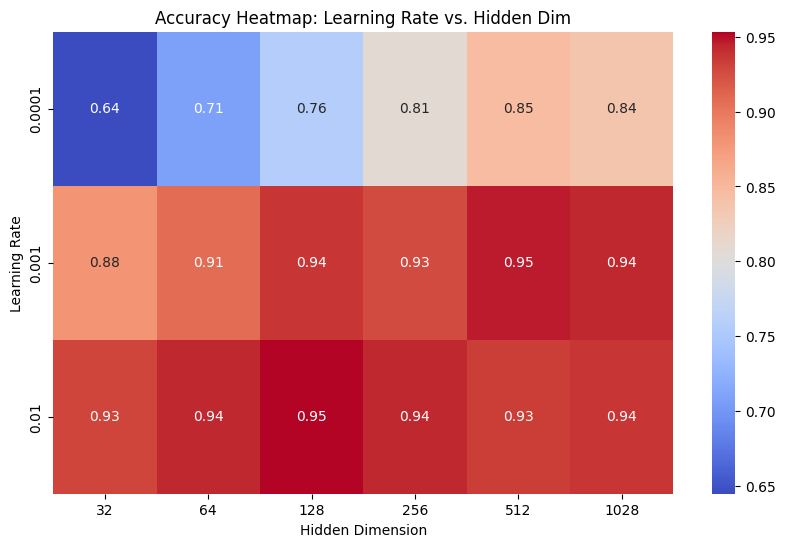

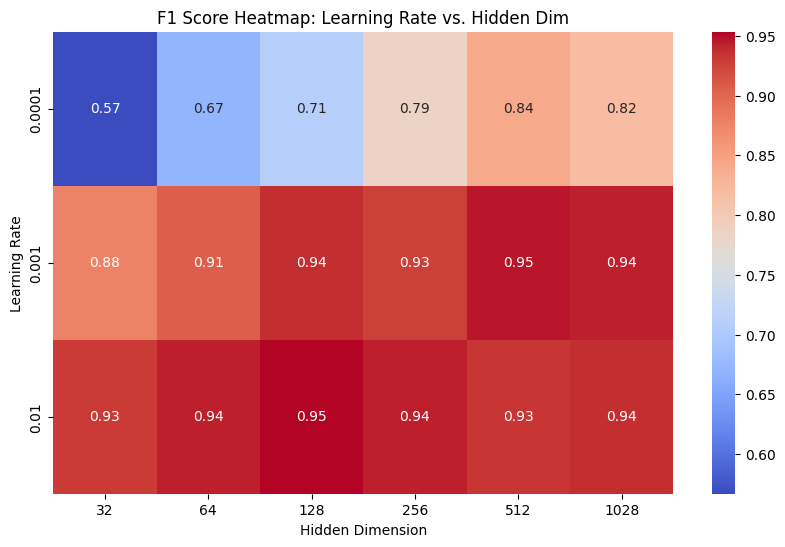

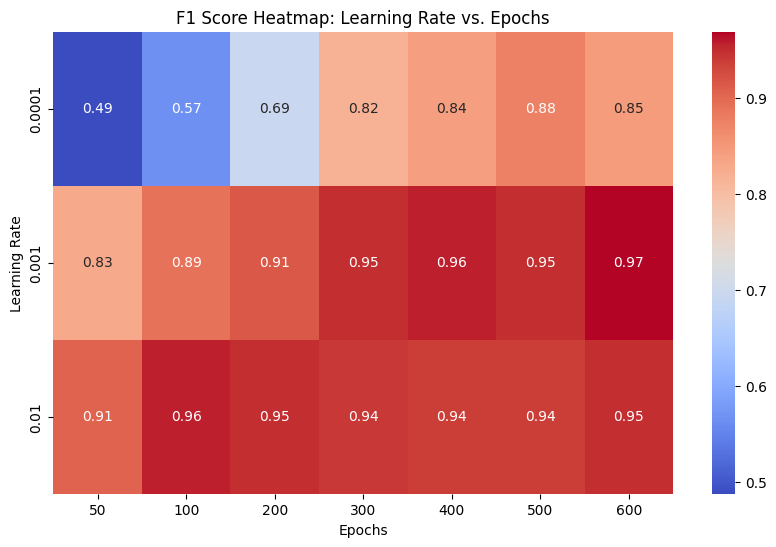

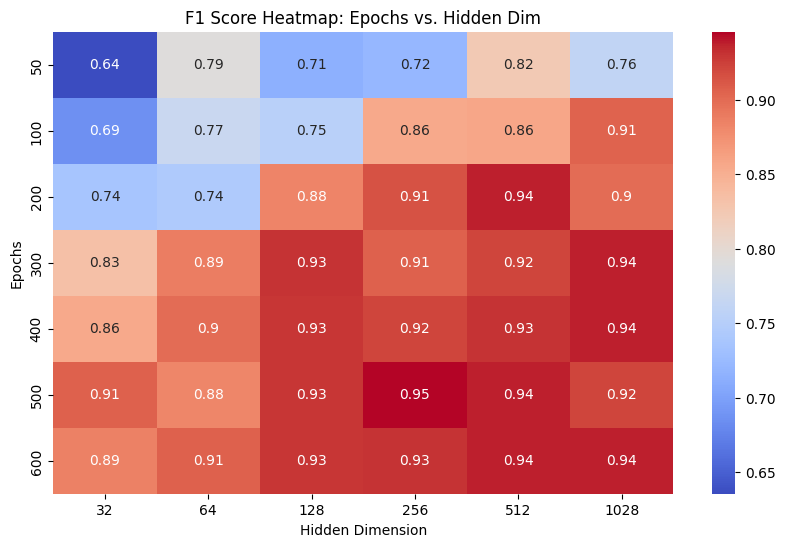

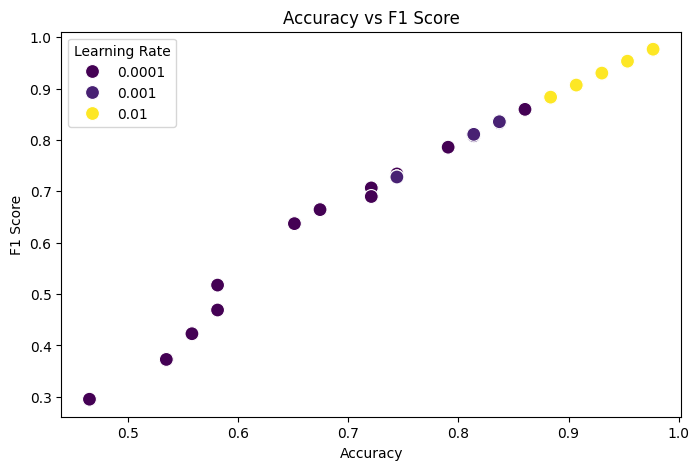

In [470]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the results to a DataFrame for easy plotting
results_df = pd.DataFrame(results, columns=["Learning Rate", "Epochs", "Hidden Dim", "Accuracy", "F1 Score"])

# Plot Accuracy vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='Accuracy', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("Accuracy Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Epochs
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Epochs', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Epochs")
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

# Plot F1 Score vs Epochs and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Epochs', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Epochs vs. Hidden Dim")
plt.ylabel('Epochs')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot Accuracy vs F1 Score (Scatter plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Accuracy', y='F1 Score', data=results_df, hue='Learning Rate', palette='viridis', s=100)
plt.title("Accuracy vs F1 Score")
plt.xlabel('Accuracy')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.show()

Now lets perform again to get the results. 

In [471]:

simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=512, output_dim=len(set(y_train)))

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train, y_train=y_train, criterion=criterionCEL, optimizer=optimizerAdam, epochs=300)
accuracy, f1 = evaluate_model(model, X_test, y_test)

Epoch 0, Loss: 3.4886
Epoch 10, Loss: 0.6700
Epoch 20, Loss: 0.4877
Epoch 30, Loss: 0.5573
Epoch 40, Loss: 0.3059
Epoch 50, Loss: 0.2603
Epoch 60, Loss: 0.2092
Epoch 70, Loss: 0.1845
Epoch 80, Loss: 0.1603
Epoch 90, Loss: 0.1460
Epoch 100, Loss: 0.1353
Epoch 110, Loss: 0.1259
Epoch 120, Loss: 0.1150
Epoch 130, Loss: 0.1060
Epoch 140, Loss: 0.0972
Epoch 150, Loss: 0.0895
Epoch 160, Loss: 0.0825
Epoch 170, Loss: 0.0756
Epoch 180, Loss: 0.0698
Epoch 190, Loss: 0.0644
Epoch 200, Loss: 0.0594
Epoch 210, Loss: 0.0548
Epoch 220, Loss: 0.0506
Epoch 230, Loss: 0.0466
Epoch 240, Loss: 0.0431
Epoch 250, Loss: 0.0399
Epoch 260, Loss: 0.0369
Epoch 270, Loss: 0.0342
Epoch 280, Loss: 0.0317
Epoch 290, Loss: 0.0294
Test Accuracy: 0.98
Test F1 Score: 0.98


## 1.4 Trying Multiple Hidden Layers

Improve with deeper MLP architecture to see if it cohorts any differnces 

In [ ]:
class MLPWithMultipleHiddenLayers(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation_function, output_activation_function):
        super(MLPWithMultipleHiddenLayers, self).__init__()
        
        layers = []
        current_dim = input_dim
        
        # Create multiple hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(activation_function) 
            current_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(current_dim, output_dim))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:

simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=512, output_dim=2)

multiple_hidden_layer_model = MLPWithMultipleHiddenLayers(input_dim=X_train.shape[1], hidden_dims=[64, 32], output_dim=2, 
                                                          activation_function=nn.ReLU(), output_activation_function=nn.Sigmoid())

criterion = nn.CrossEntropyLoss()
optimizer_simple_mlp = optim.Adam(simple_mlp_model.parameters(), lr=0.001)
optimizer_multiple_hidden_layer = optim.Adam(multiple_hidden_layer_model.parameters(), lr=0.001)

simple_mlp_model = train_model(simple_mlp_model, X_train, y_train, criterion, optimizer_simple_mlp, epochs=300)
multiple_hidden_layer_model= train_model(multiple_hidden_layer_model, X_train, y_train, criterion, optimizer_multiple_hidden_layer, epochs=50)

accuracy_simple, f1_simple = evaluate_model(simple_mlp_model, X_test, y_test)
accuracy_multiple, f1_multiple = evaluate_model(multiple_hidden_layer_model, X_test, y_test)

print(f"Simple MLP - Accuracy: {accuracy_simple:.2f}, F1 Score: {f1_simple:.2f}")
print(f"Multiple Hidden Layer MLP - Accuracy: {accuracy_multiple:.2f}, F1 Score: {f1_multiple:.2f}")


Epoch 0, Loss: 2.2010
Epoch 10, Loss: 0.8641
Epoch 20, Loss: 0.5879
Epoch 30, Loss: 0.4086
Epoch 40, Loss: 0.2881
Epoch 50, Loss: 0.2157
Epoch 60, Loss: 0.1778
Epoch 70, Loss: 0.1590
Epoch 80, Loss: 0.1414
Epoch 90, Loss: 0.1298
Epoch 100, Loss: 0.1169
Epoch 110, Loss: 0.1061
Epoch 120, Loss: 0.0967
Epoch 130, Loss: 0.0872
Epoch 140, Loss: 0.0797
Epoch 150, Loss: 0.0724
Epoch 160, Loss: 0.0663
Epoch 170, Loss: 0.0607
Epoch 180, Loss: 0.0555
Epoch 190, Loss: 0.0509
Epoch 200, Loss: 0.0466
Epoch 210, Loss: 0.0427
Epoch 220, Loss: 0.0392
Epoch 230, Loss: 0.0360
Epoch 240, Loss: 0.0331
Epoch 250, Loss: 0.0304
Epoch 260, Loss: 0.0280
Epoch 270, Loss: 0.0258
Epoch 280, Loss: 0.0237
Epoch 290, Loss: 0.0221
Epoch 0, Loss: 1.4238
Epoch 10, Loss: 0.7529
Epoch 20, Loss: 0.6361
Epoch 30, Loss: 0.5994
Epoch 40, Loss: 0.5506
Test Accuracy: 0.98
Test F1 Score: 0.98
Test Accuracy: 0.72
Test F1 Score: 0.70
Simple MLP - Accuracy: 0.98, F1 Score: 0.98
Multiple Hidden Layer MLP - Accuracy: 0.72, F1 Score:

It seems like the simple MLP outperforms the multiple hidden layer mlp probably due to the not complex problem of the dataset with the tuned hyperparameters.

## 1.5 Dropout / Activaiton Function Optimization

Lets try to see if a dropout or activation would work improve the performance of the model.

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_function, dropout_rate=0.0):
        super(SimpleMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation_function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)  
        x = self.dropout(x)  
        x = self.fc2(x)          
        return x

def train_model(model, X_train, y_train, criterion, optimizer, epochs=300):
    model.train()
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    return model

def cross_validate(X, y, model_class, activation_functions, dropout_rates, k=5, epochs=300):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    best_accuracy = 0
    best_f1 = 0
    best_params = None
    
    activation_function_names = {
        nn.ReLU(): 'ReLU',
        nn.Sigmoid(): 'Sigmoid',
        nn.Tanh(): 'Tanh'
    }
    
    for activation_function in activation_functions:
        for dropout_rate in dropout_rates:
            activation_name = activation_function_names.get(activation_function, str(activation_function))
            print(f"Testing activation function: {activation_name} with dropout rate: {dropout_rate}")
            
            accuracies = []
            f1_scores = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"Training fold {fold + 1}/{k}")
                
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                model = model_class(input_dim=X.shape[1], hidden_dim=512, output_dim=2,
                                    activation_function=activation_function, dropout_rate=dropout_rate)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                
                model = train_model(model, X_train, y_train, criterion, optimizer, epochs)
                
                model.eval()
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val, dtype=torch.long)
                
                with torch.no_grad():
                    outputs = model(X_val_tensor)
                    preds = torch.argmax(outputs, dim=1)
                
                accuracy = accuracy_score(y_val, preds.numpy())
                f1 = f1_score(y_val, preds.numpy())
                
                accuracies.append(accuracy)
                f1_scores.append(f1)
            
            avg_accuracy = sum(accuracies) / len(accuracies)
            avg_f1 = sum(f1_scores) / len(f1_scores)
            
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_f1 = avg_f1
                best_params = (activation_name, dropout_rate)
    
    print(f"Best Activation Function: {best_params[0]} with Dropout Rate: {best_params[1]}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Best F1 Score: {best_f1:.4f}")
    
    return best_params, best_accuracy, best_f1

activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
dropout_rates = [0.0, 0.2, 0.5]

#  cross-validation with grid search
best_params, best_accuracy, best_f1 = cross_validate(X_train, y_train, SimpleMLP, activation_functions, dropout_rates, k=5, epochs=300)


Testing activation function: ReLU() with dropout rate: 0.0
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Testing activation function: ReLU() with dropout rate: 0.2
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Testing activation function: ReLU() with dropout rate: 0.5
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Testing activation function: Sigmoid() with dropout rate: 0.0
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Testing activation function: Sigmoid() with dropout rate: 0.2
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Testing activation function: Sigmoid() with dropout rate: 0.5
Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Testing activation function: Tanh() with dropout rate: 0.0
Training fold 1/5
Training fold 2/5
Tr

The grid search found that no dropout rate and the by the tanh() function is the best parameters. 

## 1.6 Cross Validation (w/o Hyperparameter Tuning)

Now lets perform the k-fold with the best hyperparameters and chosen model without hyperparameter tuning to see the average performance with different dataset folds. 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

def cross_validate(X, y, k=5, epochs=300):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}/{k}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = SimpleMLP(input_dim=X.shape[1], hidden_dim=512, output_dim=2, activation_function=nn.Tanh())
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model = train_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)
        
        model.eval()
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        with torch.no_grad():
            outputs = model(X_val_tensor)
            preds = torch.argmax(outputs, dim=1) 
        
        accuracy = accuracy_score(y_val, preds.numpy())
        f1 = f1_score(y_val, preds.numpy())
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
    
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1 = sum(f1_scores) / len(f1_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_accuracy, avg_f1

avg_accuracy, avg_f1 = cross_validate(X_train, y_train, k=5, epochs=300)

Training fold 1/5
Training fold 2/5
Training fold 3/5
Training fold 4/5
Training fold 5/5
Average Accuracy: 0.9649
Average F1 Score: 0.9699


## 1.7 Inferencing

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

df_voting_inference = pd.read_csv("../data/cleaned/votings_cleaned_infer.csv")
display(df_voting_inference)
X_infer = df_voting_inference.drop(columns=['ID']).values
X_infer_tensor = torch.tensor(X_infer, dtype=torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_infer_tensor = X_infer_tensor.to(device)

simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=512, output_dim=len(set(y_train)), activation_function=nn.Tanh())
simple_mlp_model = simple_mlp_model.to(device)

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train, y_train=y_train, criterion=criterionCEL, optimizer=optimizerAdam, epochs=300)
model = model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(X_infer_tensor)
    preds = torch.argmax(outputs, dim=1)

label_mapping = {1: "democrat", 0: "republican"}
df_predictions = pd.DataFrame({
    "ID": df_voting_inference['ID'],
    "Class": [label_mapping[pred.item()] for pred in preds]
})

display(df_predictions)
df_predictions.to_csv("../data/results/voting_mlp_results.csv", index=False)


,Unnamed: 0,ID,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-crporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports
0,0,190,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,285,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN
2,2,251,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,3,40,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
4,4,91,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,181,NaN,NaN,1.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN
213,213,287,0.0,0.0,1.0,0.0,0.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,0.0,1.0,1.0
214,214,434,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0
215,215,17,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,1.0,1.0,1.0,NaN,0.0,0.0


,ID,Class
0,190,democrat
1,285,republican
2,251,republican
3,40,democrat
4,91,democrat
...,...,...
212,181,republican
213,287,republican
214,434,republican
215,17,republican


# MLP Dataset 2: Reviews

## 2.1 Reading in Data

In [ ]:
from sklearn.model_selection import train_test_split


df_reviews = pd.read_csv("../data/raw/kaggle/reviews/amazon_review_ID.shuf.lrn.csv")

X = df_reviews.drop(columns=['Class','ID']).values 
y = df_reviews['Class'].values  

label_mapping = {name: idx for idx, name in enumerate(set(y))}
y = [label_mapping[name] for name in y]
seed = 12347303
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 2.2 Initial MLP Model 

In [479]:

simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)), activation_function=nn.ReLU())

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train, y_train=y_train, criterion=criterionCEL, optimizer=optimizerAdam, epochs=50)
accuracy, f1 = evaluate_model(model, X_test, y_test)

Test Accuracy: 0.35
Test F1 Score: 0.33


The performance is pretty bad with an Accuracy of 35 percentile points. Now lets perform the hyperparameter tuning and see if changing the learning rate, epochs and dimension space improves the result.

## 2.3 Hyperparameter Tuning (LR; Epochs, Dems)

In [ ]:
import itertools
import torch.optim as optim
from sklearn.metrics import f1_score

learning_rates = [0.0001,  0.001, 0.01]
epochs_list = [20, 30, 40, 50, 100, 200]
hidden_dims = [32, 64, 128, 264, 512, 1028]

def grid_search(X_train, y_train, X_test, y_test, model_class, criterion, epochs_list, learning_rates, hidden_dims):
    best_f1 = 0
    best_params = None
    results = []

    for lr, epochs, hidden_dim in itertools.product(learning_rates, epochs_list, hidden_dims):
        print(f"Training with lr={lr}, epochs={epochs}, hidden_dim={hidden_dim}")
        
        model = model_class(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)), activation_function=nn.ReLU())
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        model = train_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)
        
        accuracy, f1 = evaluate_model(model, X_test, y_test)
        
        results.append((lr, epochs, hidden_dim, accuracy, f1))
        
        if f1 > best_f1:
            best_f1 = f1
            best_params = (lr, epochs, hidden_dim)
    
    return best_params, results

best_params, results = grid_search(X_train, y_train, X_test, y_test, 
                                   model_class=SimpleMLP, criterion=nn.CrossEntropyLoss(), 
                                   epochs_list=epochs_list, learning_rates=learning_rates, hidden_dims=hidden_dims)

print(f"Best Hyperparameters: {best_params}")


Training with lr=0.0001, epochs=20, hidden_dim=32
Test Accuracy: 0.11
Test F1 Score: 0.06
Training with lr=0.0001, epochs=20, hidden_dim=64
Test Accuracy: 0.14
Test F1 Score: 0.09
Training with lr=0.0001, epochs=20, hidden_dim=128
Test Accuracy: 0.13
Test F1 Score: 0.08
Training with lr=0.0001, epochs=20, hidden_dim=264
Test Accuracy: 0.08
Test F1 Score: 0.03
Training with lr=0.0001, epochs=20, hidden_dim=512
Test Accuracy: 0.11
Test F1 Score: 0.07
Training with lr=0.0001, epochs=20, hidden_dim=1028
Test Accuracy: 0.11
Test F1 Score: 0.07
Training with lr=0.0001, epochs=30, hidden_dim=32
Test Accuracy: 0.18
Test F1 Score: 0.13
Training with lr=0.0001, epochs=30, hidden_dim=64
Test Accuracy: 0.17
Test F1 Score: 0.12
Training with lr=0.0001, epochs=30, hidden_dim=128
Test Accuracy: 0.13
Test F1 Score: 0.13
Training with lr=0.0001, epochs=30, hidden_dim=264
Test Accuracy: 0.13
Test F1 Score: 0.08
Training with lr=0.0001, epochs=30, hidden_dim=512
Test Accuracy: 0.21
Test F1 Score: 0.16
Tr

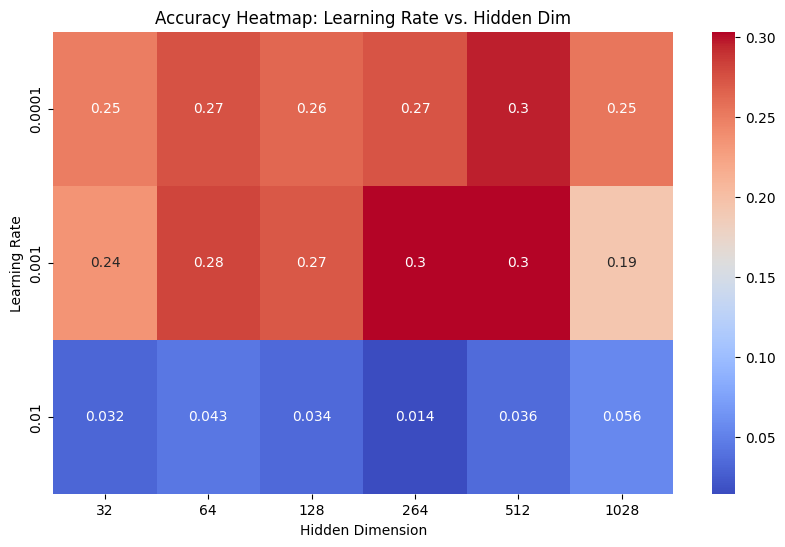

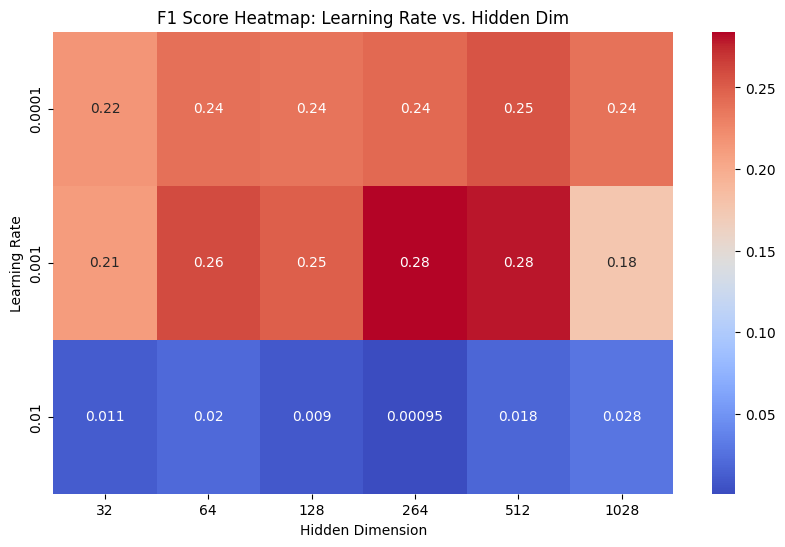

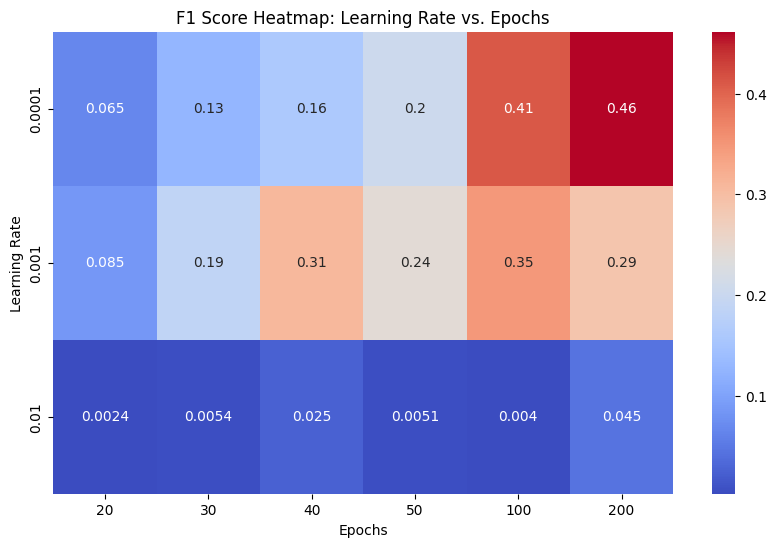

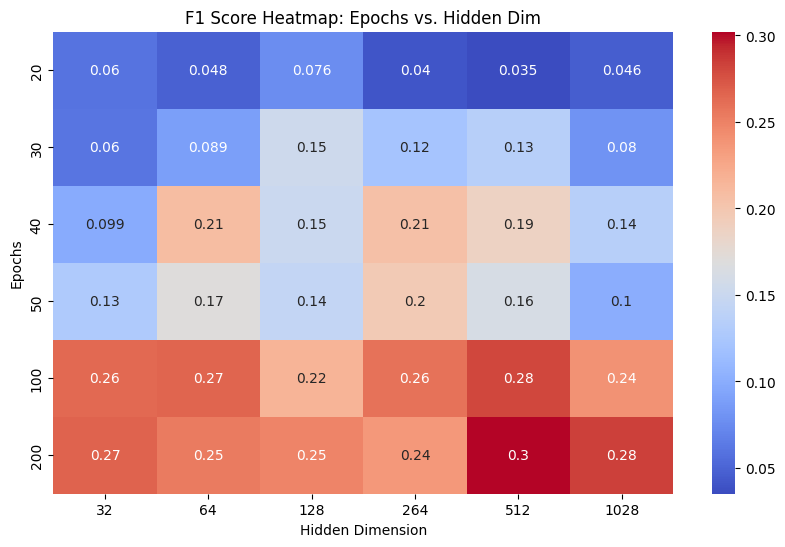

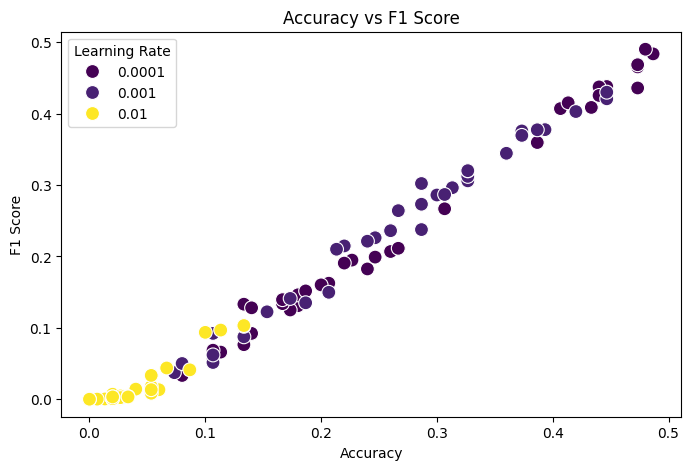

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

results_df = pd.DataFrame(results, columns=["Learning Rate", "Epochs", "Hidden Dim", "Accuracy", "F1 Score"])

# Plot Accuracy vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='Accuracy', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("Accuracy Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Epochs
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Epochs', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Epochs")
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

# Plot F1 Score vs Epochs and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Epochs', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Epochs vs. Hidden Dim")
plt.ylabel('Epochs')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot Accuracy vs F1 Score (Scatter plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Accuracy', y='F1 Score', data=results_df, hue='Learning Rate', palette='viridis', s=100)
plt.title("Accuracy vs F1 Score")
plt.xlabel('Accuracy')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.show()

The Grid Search gave the result that (0.0001, 200, 64) is the optimal setup, so a learning rate of 0.001, epoch of 100 and hidden dimension of 64. Lets apply that again to see the performance metrics. However when we tried it with 1000 hidden dimension we got a better result with 0.58 accuracy. 

In [482]:

simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=1028, output_dim=len(set(y_train)), activation_function=nn.ReLU())

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.0001)

model = train_model(simple_mlp_model, X_train=X_train, y_train=y_train, criterion=criterionCEL, optimizer=optimizerAdam, epochs=200)
accuracy, f1 = evaluate_model(model, X_test, y_test)

Test Accuracy: 0.62
Test F1 Score: 0.63


This improved the accuracy significantly however still not satisfiable. 

## 2.4 Trying Multiple Hidden Layers

Lets see if adding multiple layers will improve the result. 

In [ ]:
simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=1000, output_dim=len(set(y_train)), activation_function=nn.ReLU())

multiple_hidden_layer_model = MLPWithMultipleHiddenLayers(input_dim=X_train.shape[1], hidden_dims=[1024, 1024, 1024],output_dim=len(set(y_train)), 
                                                          activation_function=nn.ReLU(), output_activation_function=nn.ReLU())

criterion = nn.CrossEntropyLoss()
optimizer_simple_mlp = optim.Adam(simple_mlp_model.parameters(), lr=0.0001)
optimizer_multiple_hidden_layer = optim.Adam(multiple_hidden_layer_model.parameters(), lr=0.0001)

simple_mlp_model = train_model(simple_mlp_model, X_train, y_train, criterion, optimizer_simple_mlp, epochs=200)
multiple_hidden_layer_model= train_model(multiple_hidden_layer_model, X_train, y_train, criterion, optimizer_multiple_hidden_layer, epochs=200)

accuracy_simple, f1_simple = evaluate_model(simple_mlp_model, X_test, y_test)
accuracy_multiple, f1_multiple = evaluate_model(multiple_hidden_layer_model, X_test, y_test)

print(f"Simple MLP - Accuracy: {accuracy_simple:.2f}, F1 Score: {f1_simple:.2f}")
print(f"Multiple Hidden Layer MLP - Accuracy: {accuracy_multiple:.2f}, F1 Score: {f1_multiple:.2f}")


Test Accuracy: 0.63
Test F1 Score: 0.63
Test Accuracy: 0.58
Test F1 Score: 0.58
Simple MLP - Accuracy: 0.63, F1 Score: 0.63
Multiple Hidden Layer MLP - Accuracy: 0.58, F1 Score: 0.58


Also here the simple one hidden layer with a high amount of hidden dimension worked best. 

## 2.5 Dropout / Activation Function Optimization

Now lets also try the cross validation with dropout and activation function find. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_function, dropout_rate=0.0):
        super(SimpleMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation_function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model(model, X_train, y_train, criterion, optimizer, epochs=200):
    model.train()
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)  # X_train is already a tensor
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    return model

def cross_validate(X, y, model_class, activation_functions, dropout_rates, k=5, epochs=200):
    kf = KFold(n_splits=k, shuffle=True, random_state=12347303)
    
    best_accuracy = 0
    best_f1 = 0
    best_params = None
    
    activation_function_names = {
        nn.ReLU(): 'ReLU',
        nn.Sigmoid(): 'Sigmoid',
        nn.Tanh(): 'Tanh'
    }
    
    X = np.array(X)
    y = np.array(y)
    
    for activation_function in activation_functions:
        for dropout_rate in dropout_rates:
            activation_name = activation_function_names.get(activation_function, str(activation_function))
            print(f"Testing activation function: {activation_name} with dropout rate: {dropout_rate}")
            
            accuracies = []
            f1_scores = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"Training fold {fold + 1}/{k}")
                
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Convert numpy arrays to tensors
                X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train, dtype=torch.long)
                y_val_tensor = torch.tensor(y_val, dtype=torch.long)
                
                output_dim = len(np.unique(y_train)) 
                model = model_class(input_dim=X_train.shape[1], hidden_dim=1028, output_dim=output_dim,
                                    activation_function=activation_function, dropout_rate=dropout_rate)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.0001)
                
                # Train the model
                model = train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs)
                
                # Evaluate on the validation set
                model.eval()
                
                with torch.no_grad():
                    outputs = model(X_val_tensor)
                    preds = torch.argmax(outputs, dim=1)
                
                accuracy = accuracy_score(y_val, preds.numpy())
                f1 = f1_score(y_val, preds.numpy(), average='weighted')
                
                accuracies.append(accuracy)
                f1_scores.append(f1)
            
            avg_accuracy = sum(accuracies) / len(accuracies)
            avg_f1 = sum(f1_scores) / len(f1_scores)
            
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_f1 = avg_f1
                best_params = (activation_name, dropout_rate)
    
    print(f"Best Activation Function: {best_params[0]} with Dropout Rate: {best_params[1]}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    print(f"Best F1 Score: {best_f1:.4f}")
    
    return best_params, best_accuracy, best_f1

activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
dropout_rates = [0.0, 0.1, 0.2, 0.5]

#  cross-validation with grid search
best_params, best_accuracy, best_f1 = cross_validate(X_train, y_train, SimpleMLP, activation_functions, dropout_rates, k=5, epochs=200)


Testing activation function: ReLU() with dropout rate: 0.0
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: ReLU() with dropout rate: 0.1
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: ReLU() with dropout rate: 0.2
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: ReLU() with dropout rate: 0.5
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.0
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.1
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.2
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.5
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.0
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.1
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.2
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.5
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Best Activation Function: Tanh() with Dropout Rate: 0.0
Best Accuracy: 0.6183
Best F1 Score: 0.5971


So the best activation function is tanh() with dropout rate 0.0. Lets use that and perform a cross validation without hyperpermater.

## 2.6 Cross Validation (w/o Hyperparameter Tuning)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim
import numpy as np

def cross_validate(X, y, k=5, epochs=50):

    X = np.array(X)
    y = np.array(y)

    kf = KFold(n_splits=k, shuffle=True, random_state=12347303)
    
    accuracies = []
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold + 1}/{k}")
        
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = SimpleMLP(input_dim=X.shape[1], hidden_dim=1000, output_dim=len(set(y_train)), activation_function=nn.Tanh(), dropout_rate=0.0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        
        # Convert the data to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        
        # Train the model
        model = train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs=epochs)
        
        # Evaluate the model on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            outputs = model(X_val_tensor)
            preds = torch.argmax(outputs, dim=1)  # Get predictions
        
        # Calculate accuracy and F1 score
        accuracy = accuracy_score(y_val, preds.numpy())
        f1 = f1_score(y_val, preds.numpy(), average='weighted')
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
    
    # Calculate the average accuracy and F1 score across all folds
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_f1 = sum(f1_scores) / len(f1_scores)
    
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_accuracy, avg_f1

# Perform 5-fold cross-validation
avg_accuracy, avg_f1 = cross_validate(X_train, y_train, k=5, epochs=200)


Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Average Accuracy: 0.6100
Average F1 Score: 0.5920


## 2.7 Inference

In [489]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Load inference dataset
df_reviews_infer = pd.read_csv("../data/raw/kaggle/reviews/amazon_review_ID.shuf.tes.csv")
X_infer = df_reviews_infer.drop(columns='ID').values
X_infer_tensor = torch.tensor(X_infer, dtype=torch.float32)

# 2. Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_infer_tensor = X_infer_tensor.to(device)

# 3. Load or train model (assume X_train, y_train are properly loaded and preprocessed)
simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=1028, output_dim=len(set(y_train)), activation_function=nn.Tanh())
simple_mlp_model = simple_mlp_model.to(device)

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.0001)

model = train_model(simple_mlp_model, X_train=torch.tensor(X_train, dtype=torch.float32), y_train=torch.tensor(y_train, dtype=torch.float32), criterion=criterionCEL, optimizer=optimizerAdam, epochs=200)
model = model.to(device)
model.eval()

# 4. Inference
with torch.no_grad():
    outputs = model(X_infer_tensor)
    preds = torch.argmax(outputs, dim=1)

reverted_mapping = {v: k for k, v in label_mapping.items()}
# 5. Map labels
df_predictions = pd.DataFrame({
    "ID": df_reviews_infer['ID'],
    "Class": preds
})
display(df_predictions)
df_predictions['Class'] = df_predictions['Class'].map(reverted_mapping)
display(df_predictions)
df_predictions.to_csv('../data/results/reviews_mlp.csv', index=False)

/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


,ID,Class
0,750,4
1,751,4
2,752,34
3,753,48
4,754,4
...,...,...
745,1495,32
746,1496,26
747,1497,4
748,1498,26


,ID,Class
0,750,Corn
1,751,Corn
2,752,Grove
3,753,Mahlers2nd
4,754,Corn
...,...,...
745,1495,Janson
746,1496,Morrison
747,1497,Corn
748,1498,Morrison


# 3. MLP Dataset 3. Autism

# 3.1 Reading in Data

In [503]:
from sklearn.model_selection import train_test_split

df_autism = pd.read_csv("../data/cleaned/autism_children.csv")

# exclude class for training X and ID column
X = df_autism.drop(columns=['class', 'Unnamed: 0'], axis=1).values 
y = df_autism['class'].values  

display(X)
# train test split 
seed = 12347303
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

array([[1, 1, 0, ..., 'no', 5, 'Parent'],
       [1, 1, 0, ..., 'no', 5, 'Parent'],
       [1, 1, 0, ..., 'yes', 5, 'Parent'],
       ...,
       [1, 0, 1, ..., 'no', 7, 'Parent'],
       [1, 1, 1, ..., 'no', 9, 'Parent'],
       [0, 0, 1, ..., 'no', 3, 'Parent']], shape=(288, 18), dtype=object)

In [506]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

def preprocess_features_auto(X):
    
    n_samples, n_features = X.shape
    
    processed_columns = []
    encoders = {}
    
    for col_idx in range(n_features):
        col = X[:, col_idx]
        
        # Check if column is numeric
        try:
            col_numeric = col.astype(float)
            processed_columns.append(col_numeric.reshape(-1, 1))
        except ValueError:
            # Column contains strings -> label encode
            le = LabelEncoder()
            col_encoded = le.fit_transform(col)
            processed_columns.append(col_encoded.reshape(-1, 1))
            encoders[col_idx] = le  # Save encoder for that column
    
    # Stack all processed columns together
    X_processed = np.hstack(processed_columns)
    
    # Convert to torch tensor
    X_tensor = torch.tensor(X_processed, dtype=torch.float32)
    
    return X_tensor


In [508]:
X_train_tensor = preprocess_features_auto(X_train)
X_test_tensor = preprocess_features_auto(X_test)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

For this dataset, as we are dealing with medical tests, espeically autism diagnosis, it is better to avoid false negatives and to have more false positives that later turn out to be false instead of having undiagnosed autism patients. Therefore we focus on recall (and optionally the F1 Score).

In [531]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
import torch

def evaluate_model_recall(model, X_test, y_test):
    model.eval()  # Set model to evaluation mode
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    with torch.no_grad():
        outputs = model(X_test_tensor)
        preds = torch.argmax(outputs, dim=1)
    
    y_true = y_test_tensor.numpy()
    y_pred = preds.numpy()
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f'Test Accuracy: {accuracy:.2f}')
    print(f'Test F1 Score: {f1:.2f}')
    print(f'Test Recall: {recall:.2f}')
    
    return accuracy, f1, recall

## 3.2 Initial MLP Model 

In [532]:
simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)), activation_function=nn.ReLU())

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train_tensor, y_train=y_train_tensor, criterion=criterionCEL, optimizer=optimizerAdam, epochs=50)
accuracy, f1, recall_score = evaluate_model_recall(model, X_test_tensor, y_test_tensor)

Test Accuracy: 0.81
Test F1 Score: 0.81
Test Recall: 0.81


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=t

For the initial model it looks like its performing quite good, however lets turn to optimizing these parameters.

## 3.3 Hyperparameter Tuning (LR; Epochs; Dems)



In [533]:
%%capture
import itertools
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score

# Grid search hyperparameters
learning_rates = [0.001, 0.01, 0.1, 0.2]
epochs_list = [20, 50, 100, 200, 250, 300, 400]
hidden_dims = [32, 64, 128, 264, 512, 1028, 1500, 2000]

# Grid search function
def grid_search(X_train, y_train, X_test, y_test, model_class, criterion, epochs_list, learning_rates, hidden_dims):
    best_recall = 0
    best_params = None
    results = []

    for lr, epochs, hidden_dim in itertools.product(learning_rates, epochs_list, hidden_dims):
        
        # Initialize the model with the current combination of hyperparameters
        model = model_class(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)), activation_function=nn.ReLU())
        
        # Initialize optimizer
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Train the model
        model = train_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)
        
        # Evaluate the model
        _, f1, recall = evaluate_model_recall(model, X_test, y_test)
        
        # Store the results
        results.append((lr, epochs, hidden_dim, f1, recall))
        
        # Update the best model if necessary
        if recall > best_recall:
            best_recall = recall
            best_params = (lr, epochs, hidden_dim)
    
    # Return the best parameters and the full results
    return best_params, results

# Call the grid search function
best_params, results = grid_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                                   model_class=SimpleMLP, criterion=nn.CrossEntropyLoss(), 
                                   epochs_list=epochs_list, learning_rates=learning_rates, hidden_dims=hidden_dims)


In [534]:
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: (0.1, 400, 32)


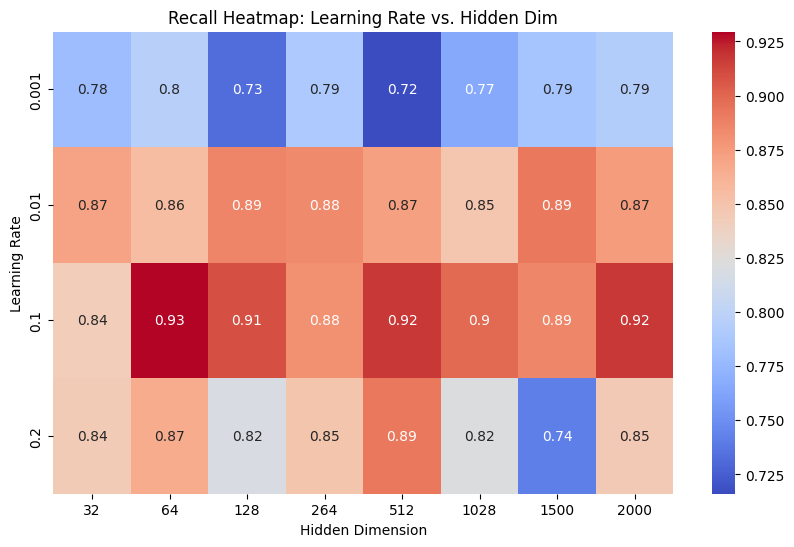

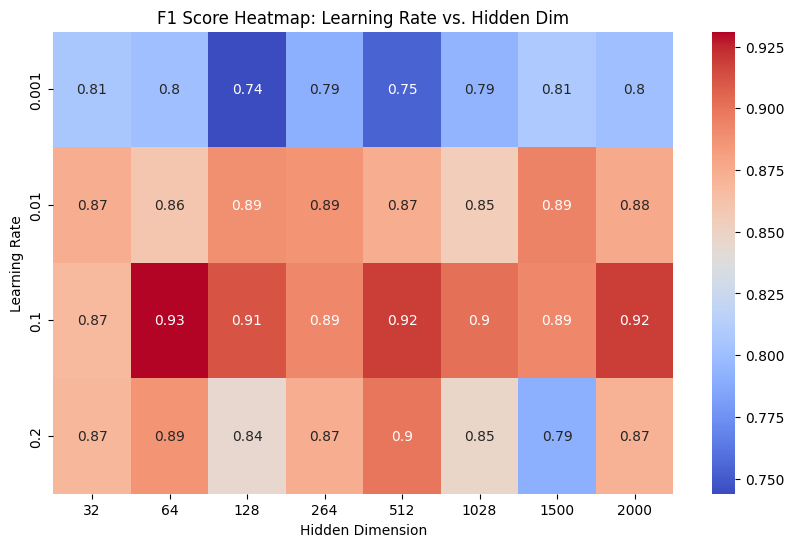

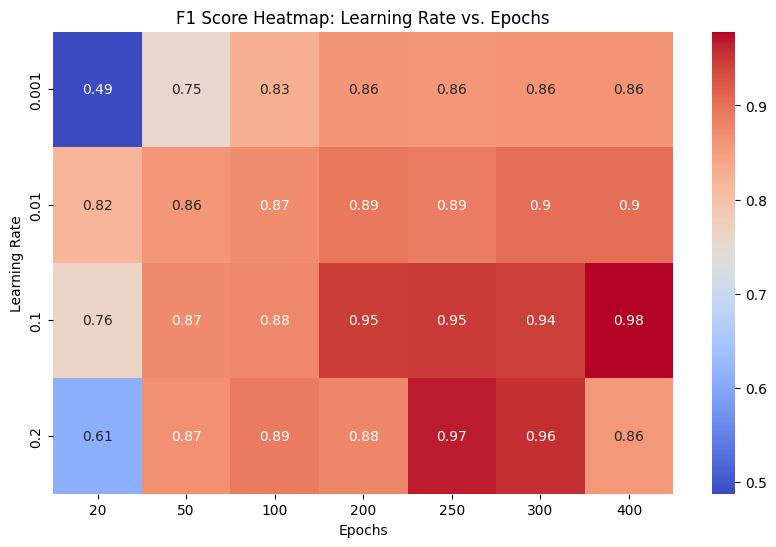

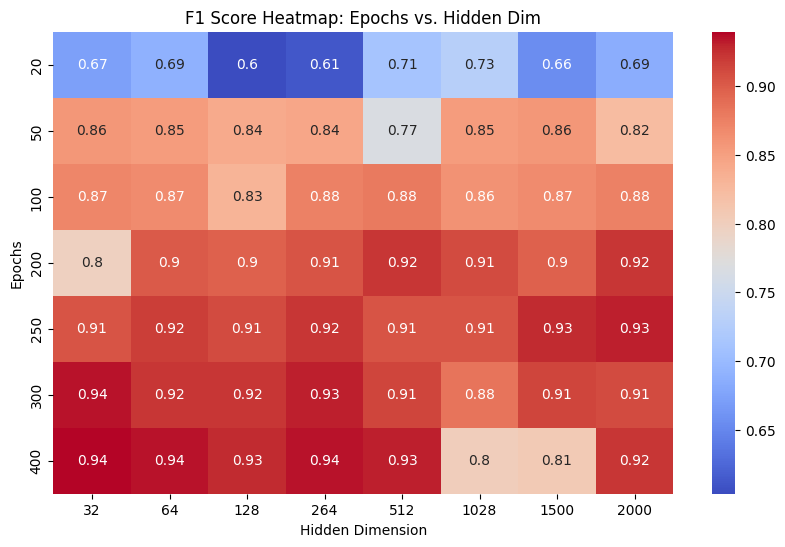

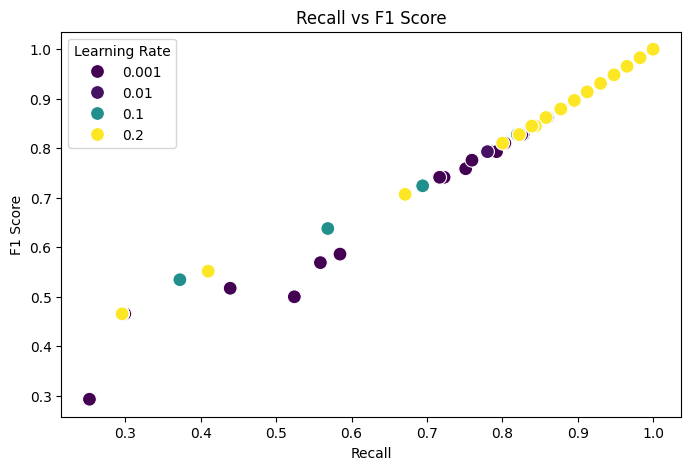

In [535]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the results to a DataFrame for easy plotting
results_df = pd.DataFrame(results, columns=["Learning Rate", "Epochs", "Hidden Dim", "Recall", "F1 Score"])

# Plot Recall vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='Recall', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("Recall Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Epochs
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Epochs', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Epochs")
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

# Plot F1 Score vs Epochs and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Epochs', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Epochs vs. Hidden Dim")
plt.ylabel('Epochs')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot Recall vs F1 Score (Scatter plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Recall', y='F1 Score', data=results_df, hue='Learning Rate', palette='viridis', s=100)
plt.title("Recall vs F1 Score")
plt.xlabel('Recall')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.show()

The best parameters chosen were (0.1, 400, 32), so a learning rate of 0.1, 300 epochs and 1028 hidden dimensions. 
Lets try that out. 


In [537]:
simple_mlp_model = SimpleMLP(input_dim=X_train_tensor.shape[1], hidden_dim=32, output_dim=len(set(y_train)), activation_function=nn.ReLU())

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.1)

model = train_model(simple_mlp_model, X_train=X_train_tensor, y_train=y_train_tensor, criterion=criterionCEL, optimizer=optimizerAdam, epochs=400)
accuracy, f1, recall = evaluate_model_recall(model, X_test_tensor, y_test_tensor)

Test Accuracy: 0.98
Test F1 Score: 0.98
Test Recall: 0.98


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=t

This seems to be almost perfect, a more complex MLP may not make sense anymore - it might make more sense to first look at the cross validation of the set and see if it performs that nice as well. 

## 3.4 Earlier Cross Validation (without Hyperparameter tuning)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim
import numpy as np

def cross_validate(X_temp, y_temp, k=5, epochs=400):

    kf = KFold(n_splits=k, shuffle=True, random_state=12347303)
    
    recalls = []
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp)):
        print(f"Training fold {fold + 1}/{k}")
        
        X_train_temp, X_val = X_temp[train_idx], X_temp[val_idx]
        y_train_temp, y_val = y_temp[train_idx], y_temp[val_idx]
        
        model = SimpleMLP(input_dim=X_train_temp.shape[1], hidden_dim=32, output_dim=len(set(y_train)), activation_function=nn.ReLU(), dropout_rate=0.0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.1)
        
        model = train_model(model, X_train_temp, y_train_temp, criterion, optimizer, epochs=epochs)
        
        model.eval() 
        with torch.no_grad():
            outputs = model(X_val)
            preds = torch.argmax(outputs, dim=1)
        
        recall = recall_score(y_val, preds.numpy())
        f1 = f1_score(y_val, preds.numpy(), average='weighted')
        
        recalls.append(recall)
        f1_scores.append(f1)
    
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)
    
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_recall, avg_f1


avg_accuracy, avg_f1 = cross_validate(X_train_tensor, y_train_tensor, k=5, epochs=400)


Training fold 1/5
Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 3/5
Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Training fold 5/5
Average Recall: 0.7636
Average F1 Score: 0.8660


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


It seems like the parameters do not perform that well when performing a cross validation test. Lets do the cross validation but with hyperparameter tuning.

## 3.5 Cross Validation Hypertuning (Dropout, LR, Dimension, AcFunc)

In [ ]:
%%capture
def cross_validate_with_recall_optimization(X_temp, y_temp, hyperparams, k=5, epochs=400):
    kf = KFold(n_splits=k, shuffle=True, random_state=12347303)
    
    best_recall = -np.inf
    best_params = None
    
    hyperparam_combinations = list(itertools.product(*hyperparams.values()))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp)):
        print(f"Training fold {fold + 1}/{k}")
        
        X_train_temp, X_val = X_temp[train_idx], X_temp[val_idx]
        y_train_temp, y_val = y_temp[train_idx], y_temp[val_idx]
        
        X_train_temp = torch.tensor(X_train_temp, dtype=torch.float32)
        y_train_temp = torch.tensor(y_train_temp, dtype=torch.long)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.long)
        
        for params in hyperparam_combinations:
            learning_rate, hidden_dim, dropout_rate, activation_function = params
            
            num_classes = len(torch.unique(y_train_temp)) 
            model = SimpleMLP(input_dim=X_train_temp.shape[1], hidden_dim=hidden_dim, 
                              output_dim=num_classes, activation_function=activation_function, 
                              dropout_rate=dropout_rate)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            
            # Train the model
            model = train_model(model, X_train_temp, y_train_temp, criterion, optimizer, epochs=epochs)
            
            # Evaluate the model on the validation set
            model.eval()  #
            with torch.no_grad():
                outputs = model(X_val)
                preds = torch.argmax(outputs, dim=1)  # Get predictions
            
            # Calculate recall score
            recall = recall_score(y_val.numpy(), preds.numpy(), average='weighted')
            
            print(f"Hyperparameters: {params}")
            print(f"Recall: {recall:.4f}")
            
            # Update the best parameters if current combination is better
            if recall > best_recall:
                best_recall = recall
                best_params = params
    
    print(f"\nBest Hyperparameters based on Recall: {best_params}")
    print(f"Best Recall: {best_recall:.4f}")
    
    return best_params, best_recall


hyperparams = {
    'learning_rate': [0.001, 0.01, 0.1],
    'hidden_dim': [32, 64, 128],
    'dropout_rate': [0.0, 0.1, 0.2],
    'activation_function': [nn.ReLU(), nn.Tanh(), nn.LeakyReLU()]
}

#  5-fold cross-validation with hyperparameter tuning (focused on recall)
best_params, best_recall = cross_validate_with_recall_optimization(X_train_tensor, y_train_tensor, hyperparams, k=5, epochs=400)

Output is truncated for better visibility and optimal parameters printed below. 

In [551]:
print(f"\nBest Hyperparameters based on Recall: {best_params}")
print(f"Best Recall: {best_recall:.4f}")


Best Hyperparameters based on Recall: (0.1, 32, 0.0, ReLU())
Best Recall: 1.0000


With the hyperparameters on 0.1 learning rate, 32 hidden dimensions, 0.0 dropout rate and the ReLu outputs the best recall option possible and therefore fitiing the perfect model just fine without needing to increase model architecture complexity. 

# 4 Dataset 4: Maternal Health

## 4.1 Reading in Data 

In [565]:
from sklearn.model_selection import train_test_split

df_maternal = pd.read_csv('../data/raw/uci/mental_health_risk/maternal_health_risk.csv')

risk_mapping = {
    'low risk': 0,
    'mid risk': 1,
    'high risk': 2
}

df_maternal['RiskLevel'] = df_maternal['RiskLevel'].map(risk_mapping)
display(df_maternal)
# exclude class for training X and ID column
X = df_maternal.drop(columns=['RiskLevel'], axis=1).values 
y = df_maternal['RiskLevel'].values  



# train test split 
seed = 12347303
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


In [566]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## 4.2 Initial MLP Model

In [567]:
simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)), activation_function=nn.ReLU())

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train_tensor, y_train=y_train_tensor, criterion=criterionCEL, optimizer=optimizerAdam, epochs=50)
accuracy, f1, recall_score = evaluate_model_recall(model, X_test_tensor, y_test_tensor)

Test Accuracy: 0.50
Test F1 Score: 0.49
Test Recall: 0.50


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=t

Not that great of a first result but we will lets move to hyperparameter tuning and see if it can be improved. 

## 4.3 Hyperparemeter TUning (LR; Epochs; Dems)

In [ ]:
%%capture
import itertools
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score

learning_rates = [0.001, 0.01, 0.1, 0.2]
epochs_list = [20, 50, 100, 200, 250, 300, 400]
hidden_dims = [32, 64, 128, 264, 512, 1028, 1500, 2000]

def grid_search(X_train, y_train, X_test, y_test, model_class, criterion, epochs_list, learning_rates, hidden_dims):
    best_recall = 0
    best_params = None
    results = []

    for lr, epochs, hidden_dim in itertools.product(learning_rates, epochs_list, hidden_dims):
        

        model = model_class(input_dim=X_train.shape[1], hidden_dim=64, output_dim=len(set(y_train)), activation_function=nn.ReLU())
        

        optimizer = optim.Adam(model.parameters(), lr=lr)
        

        model = train_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)
        

        _, f1, recall = evaluate_model_recall(model, X_test, y_test)
        

        results.append((lr, epochs, hidden_dim, f1, recall))
        

        if recall > best_recall:
            best_recall = recall
            best_params = (lr, epochs, hidden_dim)
    

    return best_params, results


best_params, results = grid_search(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, 
                                   model_class=SimpleMLP, criterion=nn.CrossEntropyLoss(), 
                                   epochs_list=epochs_list, learning_rates=learning_rates, hidden_dims=hidden_dims)


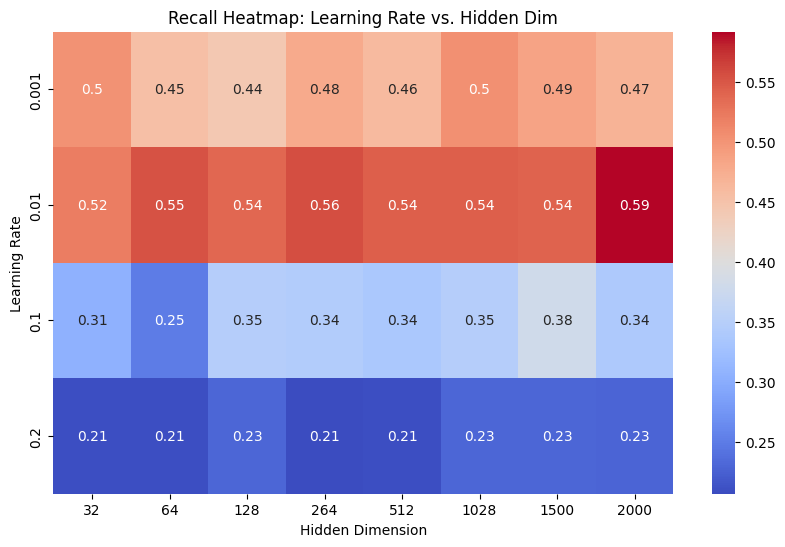

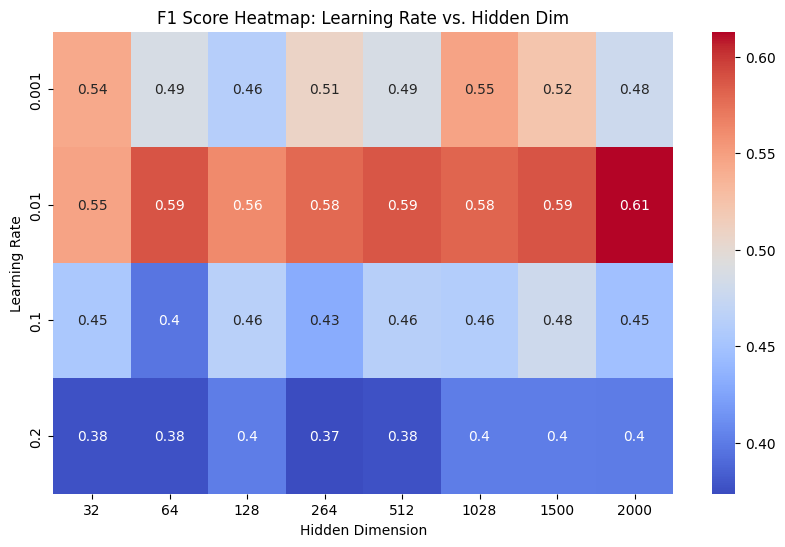

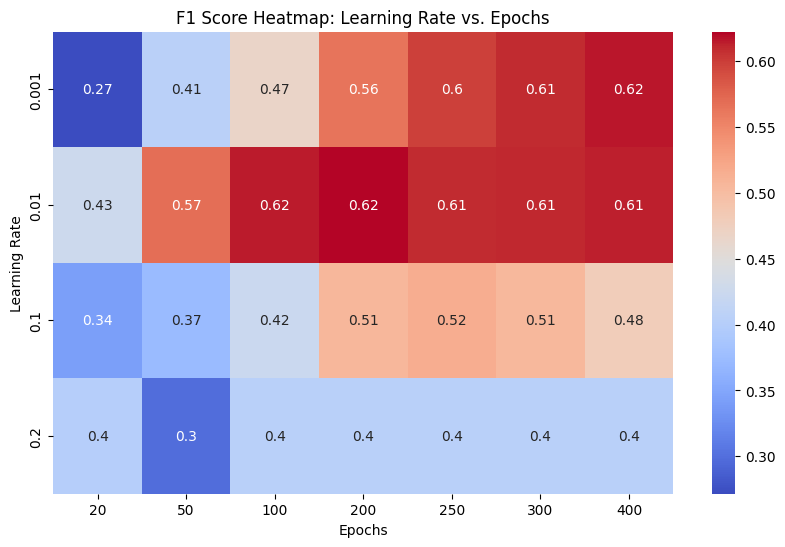

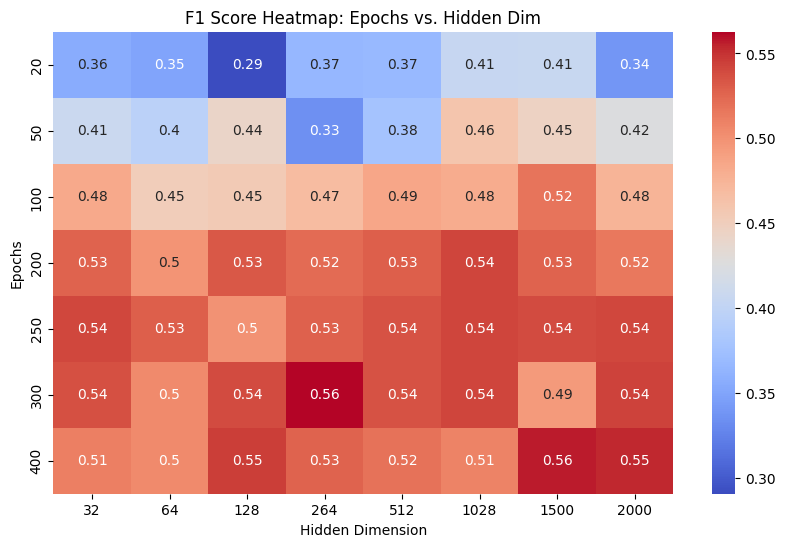

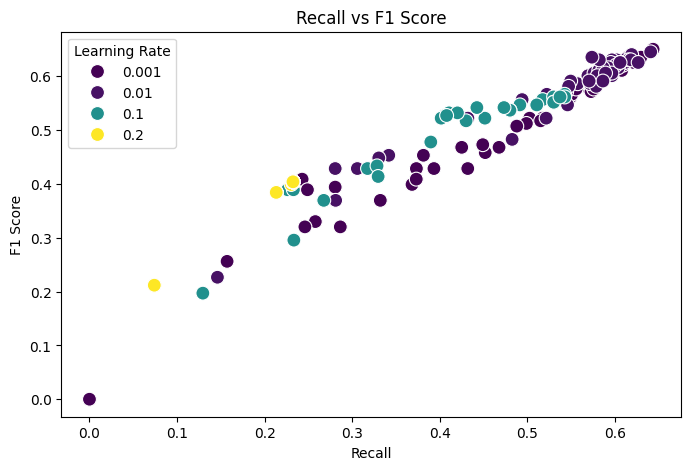

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


results_df = pd.DataFrame(results, columns=["Learning Rate", "Epochs", "Hidden Dim", "Recall", "F1 Score"])

# Plot Recall vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='Recall', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("Recall Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Hidden Dim")
plt.ylabel('Learning Rate')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot F1 Score vs Learning Rate and Epochs
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Learning Rate', columns='Epochs', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Learning Rate vs. Epochs")
plt.ylabel('Learning Rate')
plt.xlabel('Epochs')
plt.show()

# Plot F1 Score vs Epochs and Hidden Dim
plt.figure(figsize=(10, 6))
sns.heatmap(results_df.pivot_table(index='Epochs', columns='Hidden Dim', values='F1 Score', aggfunc='mean'),
            annot=True, cmap='coolwarm', cbar=True)
plt.title("F1 Score Heatmap: Epochs vs. Hidden Dim")
plt.ylabel('Epochs')
plt.xlabel('Hidden Dimension')
plt.show()

# Plot Recall vs F1 Score (Scatter plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Recall', y='F1 Score', data=results_df, hue='Learning Rate', palette='viridis', s=100)
plt.title("Recall vs F1 Score")
plt.xlabel('Recall')
plt.ylabel('F1 Score')
plt.legend(title='Learning Rate')
plt.show()

In [569]:
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: (0.001, 300, 264)


So the best hyperparameters seem to be 0.001, 300 and 264. Lets validate that again with our test/train split. 

In [571]:
simple_mlp_model = SimpleMLP(input_dim=X_train_tensor.shape[1], hidden_dim=264, output_dim=len(set(y_train)), activation_function=nn.ReLU())

criterionCEL = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(simple_mlp_model.parameters(), lr=0.001)

model = train_model(simple_mlp_model, X_train=X_train_tensor, y_train=y_train_tensor, criterion=criterionCEL, optimizer=optimizerAdam, epochs=300)
accuracy, f1, recall = evaluate_model_recall(model, X_test_tensor, y_test_tensor)

/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2317570299.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)


Test Accuracy: 0.61
Test F1 Score: 0.60
Test Recall: 0.61


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)


While it did seem to improve the recall and the other metrics, 60%  still isnt very satisfactory.

## 4.4  Trying Multiple Hidden Layers

In [ ]:
simple_mlp_model = SimpleMLP(input_dim=X_train.shape[1], hidden_dim=264, output_dim=3, activation_function=nn.ReLU())

multiple_hidden_layer_model = MLPWithMultipleHiddenLayers(input_dim=X_train.shape[1], hidden_dims=[264, 512], output_dim=3, 
                                                          activation_function=nn.ReLU(), output_activation_function=nn.ReLU())


criterion = nn.CrossEntropyLoss()
optimizer_simple_mlp = optim.Adam(simple_mlp_model.parameters(), lr=0.001)
optimizer_multiple_hidden_layer = optim.Adam(multiple_hidden_layer_model.parameters(), lr=0.001)


simple_mlp_model = train_model(simple_mlp_model, X_train_tensor, y_train_tensor, criterion, optimizer_simple_mlp, epochs=300)
multiple_hidden_layer_model= train_model(multiple_hidden_layer_model, X_train_tensor, y_train_tensor, criterion, optimizer_multiple_hidden_layer, epochs=50)


accuracy_simple, f1_simple, recall_simple = evaluate_model_recall(simple_mlp_model, X_test_tensor, y_test_tensor)
accuracy_multiple, f1_multiple, recall_multiple = evaluate_model_recall(multiple_hidden_layer_model, X_test_tensor, y_test_tensor)


print(f"Simple MLP - Recall: {recall_simple:.2f}, F1 Score: {f1_simple:.2f}")
print(f"Multiple Hidden Layer MLP - Recall: {recall_multiple:.2f}, F1 Score: {f1_multiple:.2f}")


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Test Accuracy: 0.60
Test F1 Score: 0.59
Test Recall: 0.60
Test Accuracy: 0.51
Test F1 Score: 0.50
Test Recall: 0.51
Simple MLP - Recall: 0.60, F1 Score: 0.59
Multiple Hidden Layer MLP - Recall: 0.51, F1 Score: 0.50


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/3307985696.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torc

Also here, adding a hidden layer decreases performance. Therefore we will stick with a simple MLP.

## 4.5 Dropout / Activation Function Optimization

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_function, dropout_rate=0.0):
        super(SimpleMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = activation_function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs=200):
    model.train()
    y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)  
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
    
    return model

def cross_validate(X, y, model_class, activation_functions, dropout_rates, k=5, epochs=200):
    kf = KFold(n_splits=k, shuffle=True, random_state=12347303)
    
    best_recall = 0
    best_f1 = 0
    best_params = None
    
    activation_function_names = {
        nn.ReLU(): 'ReLU',
        nn.Sigmoid(): 'Sigmoid',
        nn.Tanh(): 'Tanh'
    }
    
    X = np.array(X)
    y = np.array(y)
    
    for activation_function in activation_functions:
        for dropout_rate in dropout_rates:
            activation_name = activation_function_names.get(activation_function, str(activation_function))
            print(f"Testing activation function: {activation_name} with dropout rate: {dropout_rate}")
            
            recalls = []
            f1_scores = []
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"Training fold {fold + 1}/{k}")
                
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train, dtype=torch.long)
                y_val_tensor = torch.tensor(y_val, dtype=torch.long)
                
                output_dim = len(np.unique(y_train)) 
                model = model_class(input_dim=X_train.shape[1], hidden_dim=1028, output_dim=output_dim,
                                    activation_function=activation_function, dropout_rate=dropout_rate)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.0001)
                
                # Train the model
                model = train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs)
                
                # Evaluate on the validation set
                model.eval()
                
                with torch.no_grad():
                    outputs = model(X_val_tensor)
                    preds = torch.argmax(outputs, dim=1)
                
                recall = recall_score(y_val, preds.numpy(), average='weighted')
                f1 = f1_score(y_val, preds.numpy(), average='weighted')
                
                recalls.append(recall)
                f1_scores.append(f1)
            
            avg_recall = sum(recalls) / len(recalls)
            avg_f1 = sum(f1_scores) / len(f1_scores)
            
            if avg_recall > best_recall:
                best_recall = avg_recall
                best_f1 = avg_f1
                best_params = (activation_name, dropout_rate)
    
    print(f"Best Activation Function: {best_params[0]} with Dropout Rate: {best_params[1]}")
    print(f"Best Recall: {best_recall:.4f}")
    print(f"Best F1 Score: {best_f1:.4f}")
    
    return best_params, best_recall, best_f1

activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
dropout_rates = [0.0, 0.1, 0.2, 0.5]

#  cross-validation with grid search
best_params, best_accuracy, best_f1 = cross_validate(X_train, y_train, SimpleMLP, activation_functions, dropout_rates, k=5, epochs=200)


Testing activation function: ReLU() with dropout rate: 0.0
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: ReLU() with dropout rate: 0.1
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: ReLU() with dropout rate: 0.2
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: ReLU() with dropout rate: 0.5
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.0
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.1
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.2
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Sigmoid() with dropout rate: 0.5
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.0
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.1
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.2
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Testing activation function: Tanh() with dropout rate: 0.5
Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Best Activation Function: Tanh() with Dropout Rate: 0.0
Best Recall: 0.6164
Best F1 Score: 0.5937


Thanh Activation function with a dropout rate of 0.0 seems to perform best so lets perform a cross validation check to see its performance without a bias from the holdover.

## 4.5 Cross Validation (w/o Hyperparameter)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.optim as optim
import numpy as np

def cross_validate(X_temp, y_temp, k=5, epochs=300):

    kf = KFold(n_splits=k, shuffle=True, random_state=12347303)
    
    recalls = []
    f1_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_temp)):
        print(f"Training fold {fold + 1}/{k}")
        
        X_train_temp, X_val = X_temp[train_idx], X_temp[val_idx]
        y_train_temp, y_val = y_temp[train_idx], y_temp[val_idx]
        
        model = SimpleMLP(input_dim=X_train_temp.shape[1], hidden_dim=264, output_dim=len(set(y_train)), activation_function=nn.Tanh(), dropout_rate=0.0)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        model = train_model(model, X_train_temp, y_train_temp, criterion, optimizer, epochs=epochs)
        

        model.eval() 
        with torch.no_grad():
            outputs = model(X_val)
            preds = torch.argmax(outputs, dim=1) 
        

        recall = recall_score(y_val, preds.numpy(), average='weighted')
        f1 = f1_score(y_val, preds.numpy(), average='weighted')
        
        recalls.append(recall)
        f1_scores.append(f1)
    

    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)
    
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    
    return avg_recall, avg_f1

#  5-fold cross-validation
avg_accuracy, avg_f1 = cross_validate(X_train_tensor, y_train_tensor, k=5, epochs=300)


Training fold 1/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 2/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 3/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 4/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Training fold 5/5


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_35968/2428617021.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.long)


Average Recall: 0.6683
Average F1 Score: 0.6644


Actually, the cross validation performs a little bit better than the holdover with the optimal calculated model at about 67 percent recall and 66 percent f1 score. 